**Author**: Victor Teixidó López

In [1]:
!pip install -q transformers
!pip install -q torchvision

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

import torch

from matplotlib.pyplot import plot

In [3]:
import torch
import gc

device = 'cuda'

gc.collect()
torch.cuda.empty_cache()

# Read data from csv

For this first model we are going to just import one from Hugging Face without making any modification. For this reason, we are going to import only the test data.

In [4]:
df = pd.read_csv('/content/drive/MyDrive/UNI/tfg/dataframes/PreprocessedTestData.csv')
df.head()

,reviews,ratings
0,visit disneyland many time 60 hard enjoy park ...,1
1,back soon 5 day 72 mile walk 3 pound lose wait...,2
2,go see harry potter world amazing fan unbeliev...,2
3,mean love disneylandbut unfortunately major ri...,2
4,visit park 5 year ago excite rein act awesome ...,2


In [5]:
X_test = df['reviews']
y_test = df['ratings']

# HuggingFace model

We selected *bert-base-multilingual-uncased-sentiment* from *nlptown* to make predictions for our data. Check the model [here](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment).

In [6]:
checkpoint = "finiteautomata/bertweet-base-sentiment-analysis"

## Tokenization

After having all the data preprocessed and divided, we continue with their tokenization by words. We will use the tokenizer provided from the model selected.

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [8]:
X_test_tokenized = tokenizer(X_test.tolist(), truncation=True, padding=True, return_tensors='pt')

## Compute the model

From the model we chose, we'll compute our data to obtain rating predictions.

In [9]:
from transformers.models.auto.modeling_auto import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model = model.to(device)

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

In [10]:
from torch.utils.data import DataLoader, TensorDataset

X_test_tensors = [X_test_tokenized[key] for key in X_test_tokenized.keys()]

# Create a TensorDataset
dataset = TensorDataset(*X_test_tensors)

# Select the batch size
batch_size = 4

# Create a DataLoader to iterate over the data in batches
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [11]:
model.eval()

predictions = []
progress = 0

for batch in dataloader:
    batch = [data.to(device) for data in batch]

    # Unpack the batch and feed it to the model
    inputs = {key: value for key, value in zip(X_test_tokenized.keys(), batch)}
    output = model(**inputs)

    # Save the model output
    batch_probs = output.logits.softmax(dim=1)
    batch_probs = [[round(prob, 4) for prob in batch] for batch in batch_probs.tolist()]  # Round to 4 decimals
    predictions.extend(batch_probs)

    # Keep progress of the execution
    progress = progress + 1
    if (progress % 1000 == 0):
      print(f"Progress: {str(progress)} of {str(len(dataloader))}")

Progress: 1000 of 4677
Progress: 2000 of 4677
Progress: 3000 of 4677
Progress: 4000 of 4677


## Process the results

In [12]:
def get_index_of_max_value(list_of_values):
  max_value = max(list_of_values)
  return list_of_values.index(max_value)

predicted_labels = [get_index_of_max_value(l) for l in predictions]

## Save the results into a DataFrame

In [13]:
data = {
    'reviews': X_test.tolist(),
    'ratings': y_test.tolist(),
    'predicted_ratings': predicted_labels,
    'predicted_probs': predictions
}

results_df = pd.DataFrame(data)

In [14]:
results_df.head()

,reviews,ratings,predicted_ratings,predicted_probs
0,visit disneyland many time 60 hard enjoy park ...,1,0,"[0.493, 0.4616, 0.0454]"
1,back soon 5 day 72 mile walk 3 pound lose wait...,2,2,"[0.0024, 0.0385, 0.9591]"
2,go see harry potter world amazing fan unbeliev...,2,2,"[0.0017, 0.0214, 0.9769]"
3,mean love disneylandbut unfortunately major ri...,2,0,"[0.4561, 0.2988, 0.2451]"
4,visit park 5 year ago excite rein act awesome ...,2,2,"[0.0025, 0.4204, 0.5771]"


In [15]:
results_df.to_csv('/content/drive/MyDrive/UNI/tfg/dataframes/BaseModelData.csv', index=False)

## Read results from csv (if needed)

In [16]:
results_df = pd.read_csv('/content/drive/MyDrive/UNI/tfg/dataframes/BaseModelData.csv')
true_labels = results_df['ratings']
predicted_labels = results_df['predicted_ratings']
predicted_probs = results_df['predicted_probs']

# Model evaluation

## 3 classes classification

We will separate our data into 3 classes from the ratings we have:
- Negative (ratings with 1/2 stars)
- Neutral (ratings with 3 stars)
- Positve (ratings with 4/5 stars)

### Accuracy

In [17]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.74


### Confusion matrix

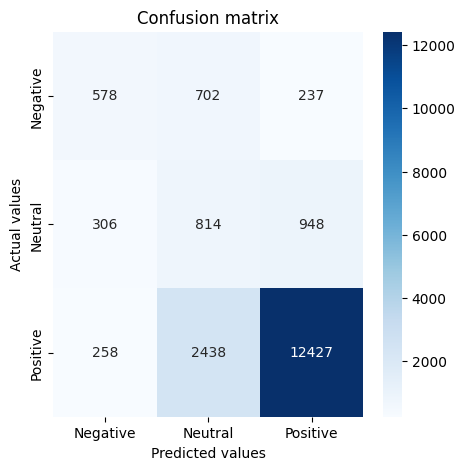

In [18]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix_df = pd.DataFrame(conf_matrix,
                              index = ["Negative", "Neutral", "Positive"],
                              columns = ["Negative", "Neutral", "Positive"])

plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix_df, cmap='Blues', annot=True, fmt='g')
plt.title("Confusion matrix")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.show()

### Receiver Operating Characteristic (ROC) Curve

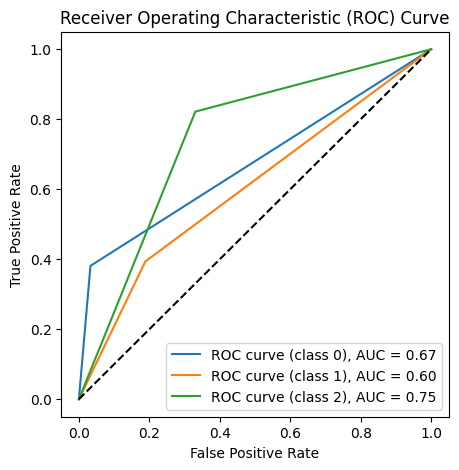


Overall AUC: 0.67


In [19]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Convert true and predicted labels to binary format for each class
true_labels_bin = label_binarize(true_labels, classes=[0, 1, 2])
predicted_labels_bin = label_binarize(predicted_labels, classes=[0, 1, 2])

fpr = dict()  # False positive rate
tpr = dict()  # True positive rate
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_labels_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(5, 5))

for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve (class {i}), AUC = {roc_auc[i]:.2f}")

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc='best')
plt.show()

# Calculate the overall AUC by averaging the AUCs of individual classes
overall_auc = sum(roc_auc.values()) / len(roc_auc)
print(f"\nOverall AUC: {overall_auc:.2f}")

### Precision, Recall and F1-score

In [20]:
from sklearn.metrics import classification_report

class_report = classification_report(true_labels, predicted_labels, target_names=["Negative", "Neutral", "Positive"])
print(class_report)

              precision    recall  f1-score   support

    Negative       0.51      0.38      0.43      1517
     Neutral       0.21      0.39      0.27      2068
    Positive       0.91      0.82      0.86     15123

    accuracy                           0.74     18708
   macro avg       0.54      0.53      0.52     18708
weighted avg       0.80      0.74      0.76     18708

